# LSTM model


c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


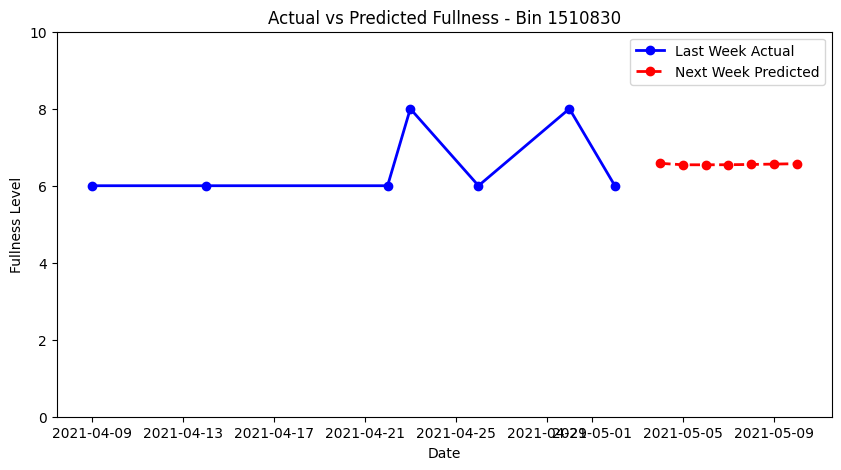

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


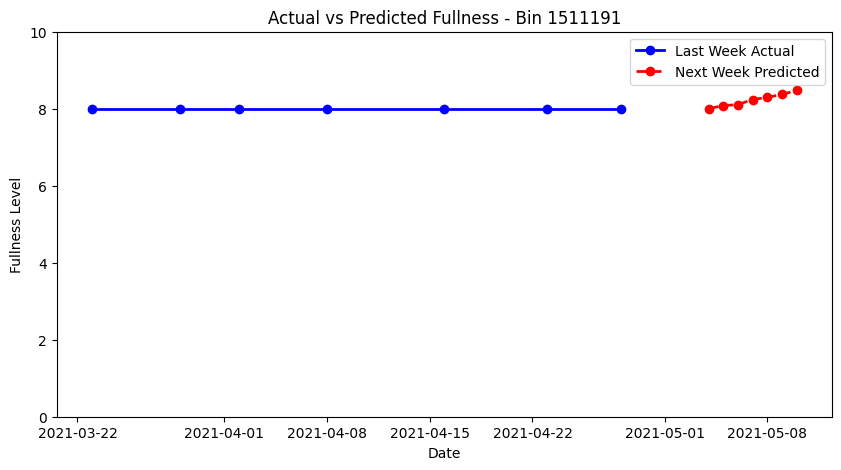

c:\Users\dhyey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


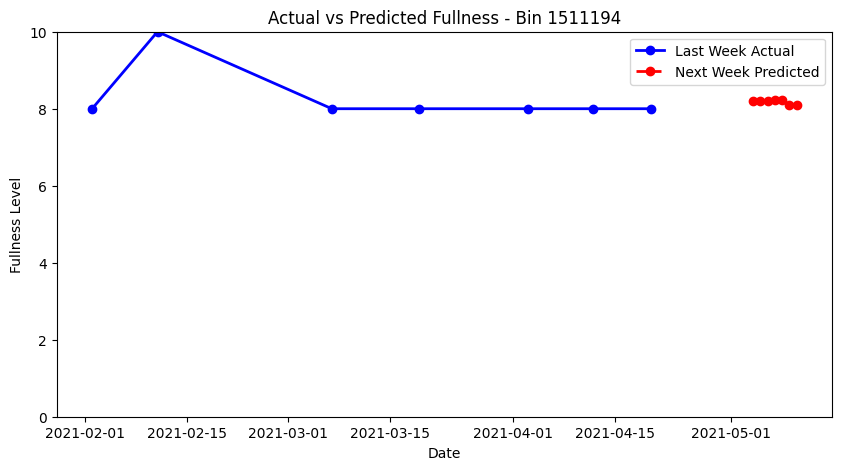

             RMSE
Bin ID           
1510830  0.905904
1511191  0.273810
1511194  0.699722


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Load resampled dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
bins_to_forecast = [1510830 , 1511191 , 1511194 ]
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to May 3, 2021
train_data = df[df['timestamp'] < "2021-05-03"]

# Function to prepare time series data for LSTM
def prepare_data(series, time_steps=10):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i : i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)

# Dictionary to store results
results = {}

# Train and predict for each bin
for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')

    # Normalize fullness values (scaling)
    scaler = MinMaxScaler()
    fullness_train = scaler.fit_transform(bin_train[['Fullness']])

    # Prepare training data
    time_steps = 10
    X_train, y_train = prepare_data(fullness_train, time_steps)

    # Reshape input for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build improved LSTM model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train the model with more epochs
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Predict the next 7 days
    predictions = []
    last_sequence = fullness_train[-time_steps:].reshape(1, time_steps, 1)

    for _ in range(7):
        pred = model.predict(last_sequence)
        predictions.append(pred[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)

    # Inverse transform predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Extract last 7 days of actual values
    last_week_actual = bin_train['Fullness'].values[-7:].reshape(-1, 1)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results[bin_id] = rmse

    # Generate timestamps for prediction
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')

    # Plot actual vs predicted with fixed y-axis
    plt.figure(figsize=(10, 5))
    plt.plot(bin_train['timestamp'].values[-7:], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)  # Blue solid line
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)  # Red dashed line
    plt.ylim(0, 10)  # Fixing y-axis from 0 to 10
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id}")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Convert results to DataFrame for RMSE table
rmse_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
rmse_df.index.name = "Bin ID"


# Print RMSE values
print(rmse_df)


# ARIMA Model


Last 7 Actual Values for Bin 1510830: [6 6 6 8 6 8 6]


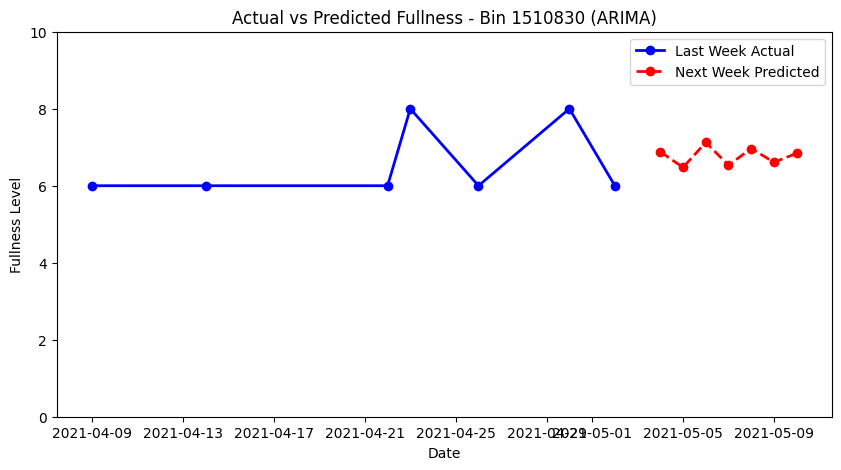

Last 7 Actual Values for Bin 1511191: [8 8 8 8 8 8 8]


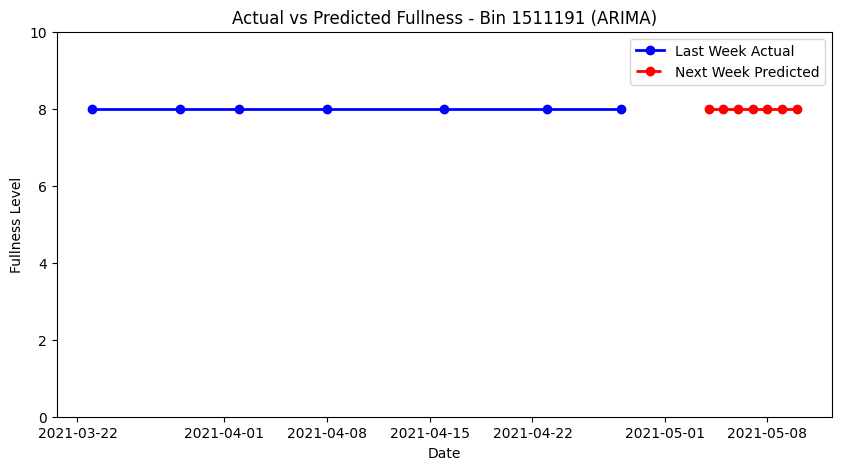

Last 7 Actual Values for Bin 1511194: [ 8 10  8  8  8  8  8]


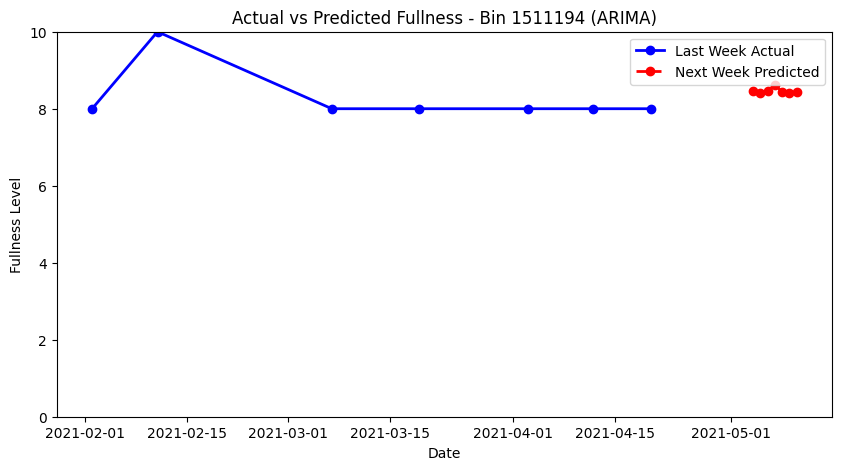

ARIMA Model RMSE for Each Bin:
{1510830: 1.0685362324997985, 1511191: 8.881784197001252e-16, 1511194: 0.7469540741647316}


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load cleaned dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
bins_to_forecast = [1510830 , 1511191 , 1511194 ]
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to May 3, 2021
train_data = df[df['timestamp'] < "2021-05-03"]

# Dictionary to store results
results = {}

# Train and predict for each bin using ARIMA
for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')

    # Extract fullness values
    fullness_train = bin_train[['Fullness']].values.flatten()

    # Print last 7 actual values to check if they are constant
    print(f"Last 7 Actual Values for Bin {bin_id}: {fullness_train[-7:]}")

    # Select ARIMA order dynamically based on stationarity check
    arima_order = (5, 0, 0) if np.std(fullness_train) < 0.1 else (5, 1, 0)

    # Fit ARIMA model
    model = ARIMA(fullness_train, order=arima_order)
    model_fit = model.fit()

    # Predict the next 7 days
    predictions = model_fit.forecast(steps=7)

    # Extract last 7 days of actual values
    last_week_actual = bin_train['Fullness'].values[-7:]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results[bin_id] = rmse

    # Generate timestamps for prediction
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')

    # Plot actual vs predicted with fixed y-axis
    plt.figure(figsize=(10, 5))
    plt.plot(bin_train['timestamp'].values[-7:], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)  # Blue solid line
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)  # Red dashed line
    plt.ylim(0, 10)  # Fixing y-axis from 0 to 10
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id} (ARIMA)")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Print RMSE values
print("ARIMA Model RMSE for Each Bin:")
print(results)


# Exponential Smoothing


Last 7 Actual Values for Bin 1510830: [6 6 6 8 6 8 6]


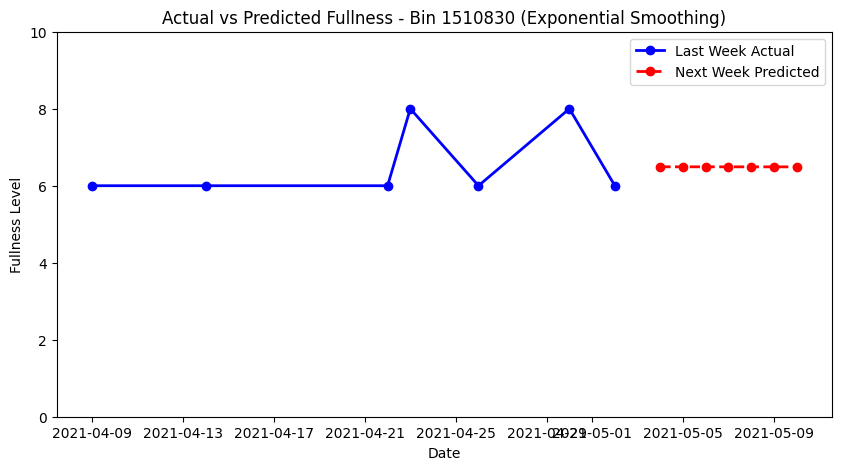

Last 7 Actual Values for Bin 1511191: [8 8 8 8 8 8 8]


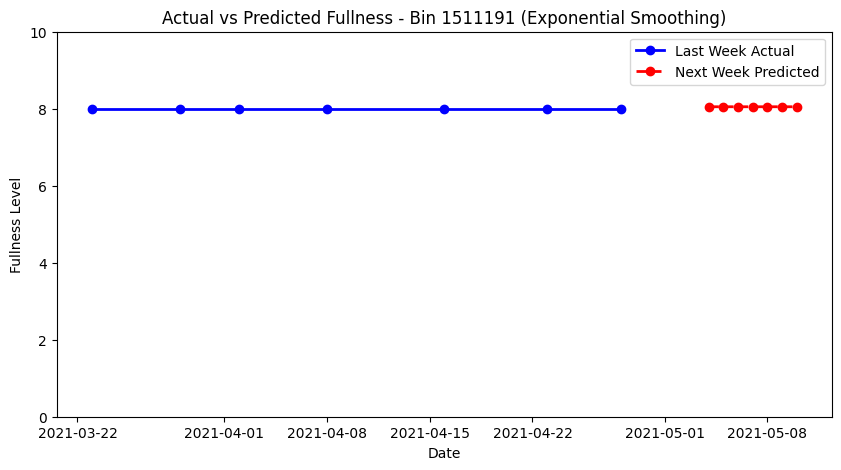

Last 7 Actual Values for Bin 1511194: [ 8 10  8  8  8  8  8]


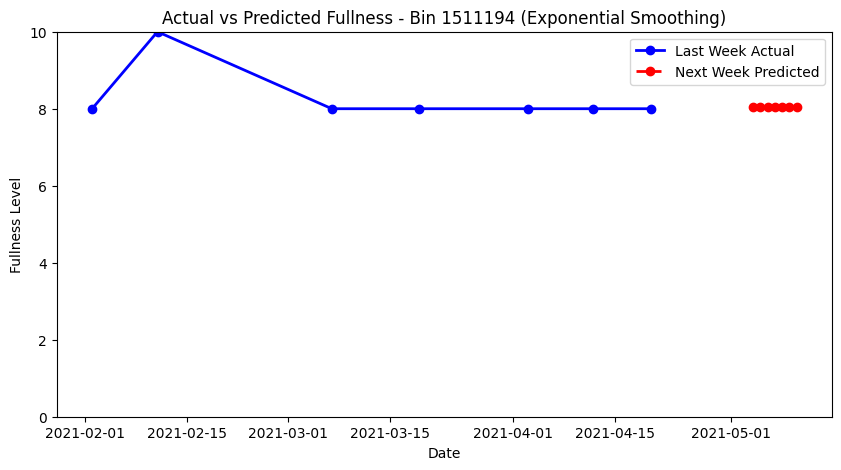

Exponential Smoothing Model RMSE for Each Bin:
{1510830: 0.9072808446278021, 1511191: 0.05118447452492732, 1511194: 0.7428896464102203}


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load cleaned dataset
df = pd.read_csv("cleaned_bin_data.csv", parse_dates=['timestamp'])

# Select bins for forecasting
bins_to_forecast = [1510830 , 1511191 , 1511194 ]
df = df[df['Bin ID'].isin(bins_to_forecast)]

# Filter data up to May 3, 2021
train_data = df[df['timestamp'] < "2021-05-03"]

# Dictionary to store results
results = {}

# Train and predict for each bin using Exponential Smoothing (ETS)
for bin_id in bins_to_forecast:
    bin_train = train_data[train_data['Bin ID'] == bin_id].sort_values(by='timestamp')

    # Extract fullness values
    fullness_train = bin_train[['Fullness']].values.flatten()

    # Print last 7 actual values to check if they are constant
    print(f"Last 7 Actual Values for Bin {bin_id}: {fullness_train[-7:]}")

    # Fit Exponential Smoothing Model
    model = ExponentialSmoothing(fullness_train, trend="add", seasonal=None, damped_trend=True)
    model_fit = model.fit()

    # Predict the next 7 days
    predictions = model_fit.forecast(steps=7)

    # Extract last 7 days of actual values
    last_week_actual = bin_train['Fullness'].values[-7:]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(last_week_actual, predictions))
    results[bin_id] = rmse

    # Generate timestamps for prediction
    future_dates = pd.date_range(start="2021-05-04", periods=7, freq='D')

    # Plot actual vs predicted with fixed y-axis
    plt.figure(figsize=(10, 5))
    plt.plot(bin_train['timestamp'].values[-7:], last_week_actual, 'bo-', label="Last Week Actual", linewidth=2)  # Blue solid line
    plt.plot(future_dates, predictions, 'ro--', label="Next Week Predicted", linewidth=2)  # Red dashed line
    plt.ylim(0, 10)  # Fixing y-axis from 0 to 10
    plt.title(f"Actual vs Predicted Fullness - Bin {bin_id} (Exponential Smoothing)")
    plt.xlabel("Date")
    plt.ylabel("Fullness Level")
    plt.legend()
    plt.show()

# Print RMSE values
print("Exponential Smoothing Model RMSE for Each Bin:")
print(results)
